In [1]:
import os
import torch
import torchvision
from tqdm import tqdm
from torchvision.models import resnet50
from torchmetrics import AUROC
from fastai.vision.all import *
from PIL import Image
import pandas as pd
from pathlib2 import Path
from torch.utils.data import Dataset, DataLoader, random_split
import matplotlib.pyplot as plt

C:\Users\lalet\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: [WinError 127] Не найдена указанная процедура
  warn(f"Failed to load image Python extension: {e}")


In [2]:
device = torch.device("cpu")
use_gpu = True
if torch.cuda.is_available():
    if use_gpu:
        device = torch.device("cuda")
else:
    print("Cuda is not available")

In [3]:
class ImageClassificationDataset(Dataset):
    """Dataset for an Image Classification"""

    def __init__(self, image_dir: str, targets: pd.DataFrame, transform=None):
        """
        Args:
            image_dir (string): Directory with all images
            targets (string): Path to csv file with annotations
            transform (callable, optional): Optional transform to be applied on images.
        """
        super().__init__()
        self.root_dir = image_dir
        self.targets = targets
        self.transform = transform

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.targets.iloc[idx, 0])
        image = Image.open(img_name)
        image = torchvision.transforms.ToTensor()(image)
        if self.transform:
            image = self.transform(image)
        targets = self.targets.iloc[idx, 1]
        targets = targets.reshape(-1)
        targets = torch.tensor(targets, dtype=torch.float)

        sample = {
            "image": image,
            "targets": targets
        }

        return image, targets

    def __len__(self):
        return len(self.targets)

In [4]:
model = resnet50(pretrained=True)
in_features = model.fc.in_features
out_features = 1
model.fc = torch.nn.Sequential(
    torch.nn.Linear(in_features, 1000, bias=True),
    torch.nn.Linear(1000, out_features, bias=True),
    torch.nn.Sigmoid()
)
model.to(device)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [5]:
temp_train_labels = pd.read_csv("train.csv")
root = Path().absolute()
train_dir = root/'train'/'train'
test_dir = root/'test'/'test'

In [6]:
dataset = ImageClassificationDataset(train_dir, temp_train_labels, transform=torchvision.transforms.RandomCrop(56))
dataset_size = len(dataset)
validation_percent = 0.2
validation_size = int(dataset_size * validation_percent)
sizes = [dataset_size - validation_size, validation_size]
train_dataset, validation_dataset = random_split(dataset, sizes)

In [7]:
n_epoch = 150
batch_size = 100
optimizer = torch.optim.Adam(model.parameters(), lr=0.00001)
loss_function = torch.nn.BCELoss()
metric = AUROC(task="binary")

In [8]:
train_loader = DataLoader(train_dataset, batch_size=batch_size)
validation_loader = DataLoader(validation_dataset, batch_size=batch_size)

In [9]:
train_losses = []
validation_losses = []
train_scores = []
validation_scores = []
for epoch in range(n_epoch):
    temp_train_labels = []
    temp_train_outputs = []
    temp_validation_labels = []
    temp_validation_outputs = []

    train_loss = 0.0
    model.train()
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        optimizer.zero_grad()

        temp_train_labels.append(labels.cpu())
        temp_train_outputs.append(outputs.cpu())

    validation_loss = 0.0
    model.eval()
    for i, data in enumerate(validation_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        outputs = model(inputs)
        loss = loss_function(outputs, labels)

        validation_loss += loss.item()
        with torch.no_grad():
            temp_validation_labels.append(labels.cpu())
            temp_validation_outputs.append(outputs.cpu())

    train_labels = torch.cat(temp_train_labels)
    train_outputs = torch.cat(temp_train_outputs)
    validation_labels = torch.cat(temp_validation_labels)
    validation_outputs = torch.cat(temp_validation_outputs)

    train_score = metric(train_outputs, train_labels)
    validation_score = metric(validation_outputs, validation_labels)

    #print(f"[Epoch: {epoch + 1}] Train loss: {train_loss/len(train_loader):.3f}\tValidation loss: {validation_loss/len(validation_loader):.3f}")
    print(f"[Epoch: {epoch + 1}] Train score: {train_score:.3f}\tValidation score: {validation_score:.3f}")

    train_losses.append(train_loss/len(train_loader))
    validation_losses.append(validation_loss/len(validation_loader))
    train_scores.append(train_score)
    validation_scores.append(validation_score)

[Epoch: 1] Train score: 0.608	Validation score: 0.712
[Epoch: 2] Train score: 0.769	Validation score: 0.813
[Epoch: 3] Train score: 0.796	Validation score: 0.825
[Epoch: 4] Train score: 0.832	Validation score: 0.830
[Epoch: 5] Train score: 0.856	Validation score: 0.833
[Epoch: 6] Train score: 0.859	Validation score: 0.860
[Epoch: 7] Train score: 0.876	Validation score: 0.884
[Epoch: 8] Train score: 0.883	Validation score: 0.898
[Epoch: 9] Train score: 0.882	Validation score: 0.873
[Epoch: 10] Train score: 0.904	Validation score: 0.905
[Epoch: 11] Train score: 0.895	Validation score: 0.912
[Epoch: 12] Train score: 0.910	Validation score: 0.907
[Epoch: 13] Train score: 0.884	Validation score: 0.902
[Epoch: 14] Train score: 0.900	Validation score: 0.907
[Epoch: 15] Train score: 0.910	Validation score: 0.914
[Epoch: 16] Train score: 0.906	Validation score: 0.906
[Epoch: 17] Train score: 0.917	Validation score: 0.924
[Epoch: 18] Train score: 0.916	Validation score: 0.898
[Epoch: 19] Train s

KeyboardInterrupt: 

Text(0.5, 1.0, 'Loss curve')

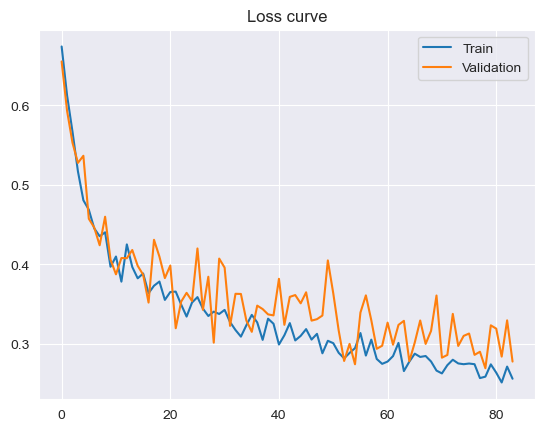

In [12]:
plt.plot(train_losses, label="Train")
plt.plot(validation_losses, label="Validation")
plt.legend()
plt.title("Loss curve")

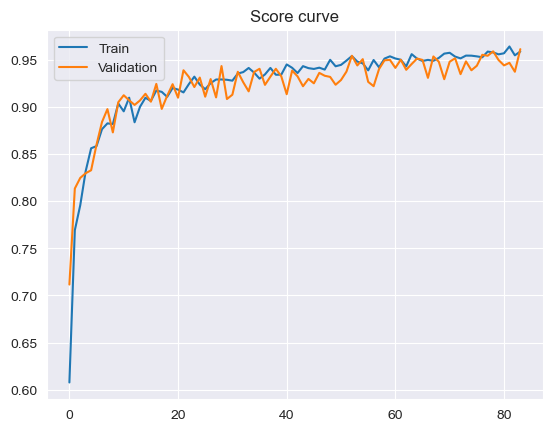

In [11]:
plt.plot(train_scores, label="Train")
plt.plot(validation_scores, label="Validation")
plt.legend()
plt.title("Score curve")
plt.show()